In [1]:
import os
import dask.dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from dotenv import load_dotenv

In [2]:
# Carregar variáveis de ambiente
load_dotenv()

# Obter variáveis de ambiente
user = os.environ.get('DB_USER')
password = os.environ.get('DB_PASSWORD')
host = os.environ.get('DB_HOST')
port = os.environ.get('DB_PORT', '5432')
database = os.environ.get('DB_NAME')

# Criar string de conexão
connection_string = f'postgresql://{user}:{password}@{host}:{port}/{database}'

# Criar conexão com o banco de dados
engine = create_engine(connection_string)

In [3]:
def load_data_in_chunks(query, engine, chunksize=50000):
    # Lista para armazenar os DataFrames Dask
    df_list = []
    
    # Ler os dados em chunks usando pandas
    for chunk in pd.read_sql(query, engine, chunksize=chunksize):
        # Converter o chunk pandas DataFrame para Dask DataFrame
        ddf_chunk = dd.from_pandas(chunk, npartitions=1)
        df_list.append(ddf_chunk)
    
    # Concatenar todos os Dask DataFrames em um único DataFrame Dask
    df = dd.concat(df_list)
    return df

In [4]:
# Only load data from the last 2 years
query = "SELECT * FROM ds_market WHERE date >= '2015-01-01'"
df = load_data_in_chunks(query, engine)

In [5]:
# Convert data types to more efficient ones
df['sales'] = df['sales'].astype('int32')
df['sell_price'] = df['sell_price'].astype('float32')

# Time Series Analysis

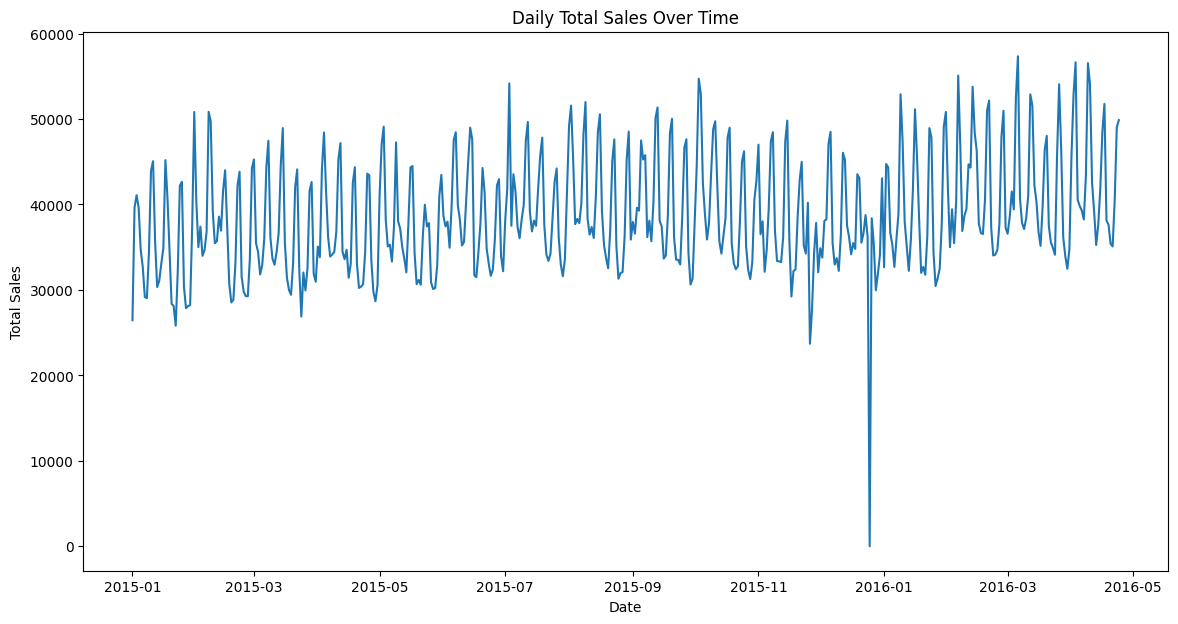

In [6]:
# Ensure 'date' is in datetime format
df['date'] = dd.to_datetime(df['date'])

# Set 'date' as the index
df = df.set_index('date')

# Resample sales data to get daily total sales
daily_sales = df['sales'].resample('D').sum().compute()

# Plot daily sales
plt.figure(figsize=(14,7))
plt.plot(daily_sales.index, daily_sales.values)
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Daily Total Sales Over Time')
plt.show()

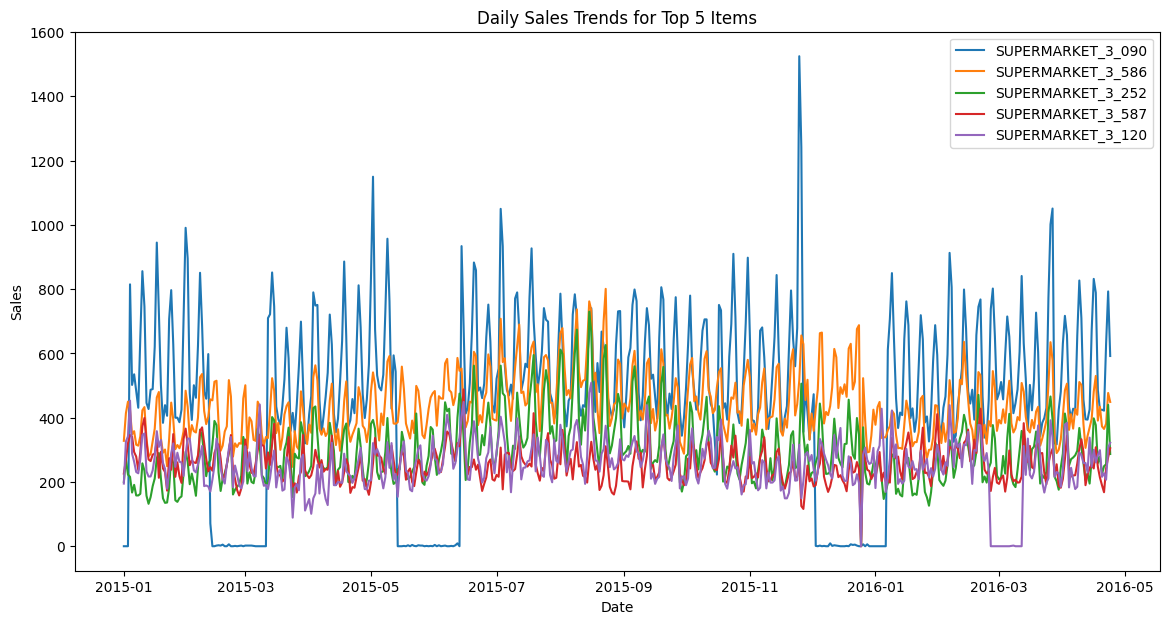

In [7]:
# Get the list of top 5 items
top_items = df.groupby('item')['sales'].sum().compute().reset_index().sort_values(by='sales', ascending=False)
top_5_items = top_items['item'].head(5).tolist()

# Filter data for top 5 items
df_top_items = df[df['item'].isin(top_5_items)]

# Group by date and item, then sum sales
item_daily_sales = df_top_items.groupby(['date', 'item'])['sales'].sum().compute().reset_index()

# Pivot the data for plotting
item_daily_sales_pivot = item_daily_sales.pivot(index='date', columns='item', values='sales')

# Plot sales trends for top 5 items
plt.figure(figsize=(14,7))
for item in top_5_items:
    plt.plot(item_daily_sales_pivot.index, item_daily_sales_pivot[item], label=item)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Daily Sales Trends for Top 5 Items')
plt.legend()
plt.show()

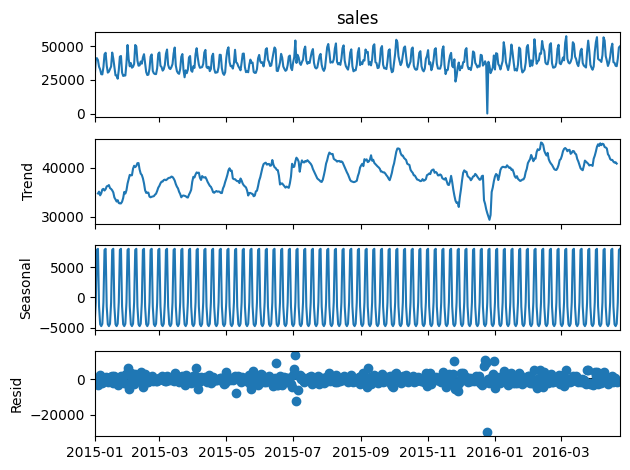

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Since statsmodels requires a pandas Series, ensure the data is in the correct format
daily_sales = daily_sales.asfreq('D')  # Ensure the index is a DateTimeIndex with daily frequency

# Perform seasonal decomposition
decomposition = seasonal_decompose(daily_sales, model='additive')

# Plot the decomposition
decomposition.plot()
plt.show()

In [9]:
# Compute average sell_price per item per day
avg_price = df.groupby(['date', 'item'])['sell_price'].mean().compute().reset_index()

# Compute total sales per item per day
total_sales = df.groupby(['date', 'item'])['sales'].sum().compute().reset_index()

# Merge the dataframes
price_sales = pd.merge(total_sales, avg_price, on=['date', 'item'])

C:\Users\rpiaz\AppData\Local\Temp\ipykernel_8304\195721184.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  item_data['price_pct_change'] = item_data['sell_price'].pct_change()
C:\Users\rpiaz\AppData\Local\Temp\ipykernel_8304\195721184.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  item_data['sales_pct_change'] = item_data['sales'].pct_change()


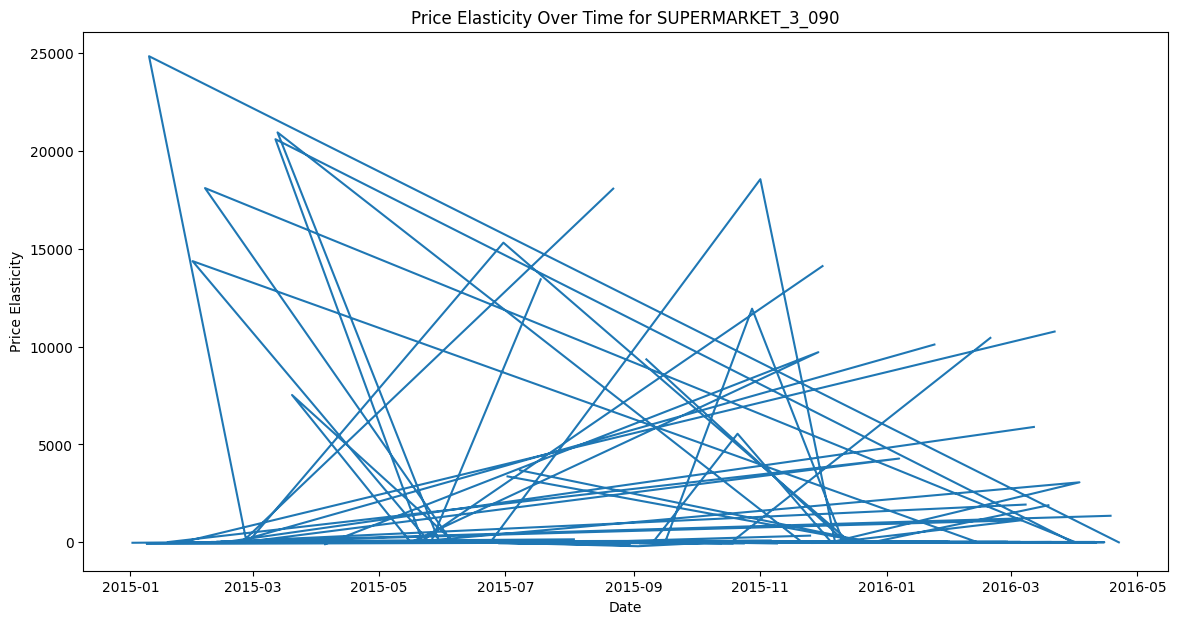

Average price elasticity for SUPERMARKET_3_090: nan


In [10]:
# For simplicity, analyze one item
item_to_analyze = top_items['item'].iloc[0]

item_data = price_sales[price_sales['item'] == item_to_analyze]

# Calculate percentage change in price and sales
item_data['price_pct_change'] = item_data['sell_price'].pct_change()
item_data['sales_pct_change'] = item_data['sales'].pct_change()

# Remove rows with NaN values
item_data = item_data.dropna()

# Calculate elasticity
item_data['elasticity'] = item_data['sales_pct_change'] / item_data['price_pct_change']

# Plot elasticity over time
plt.figure(figsize=(14,7))
plt.plot(item_data['date'], item_data['elasticity'])
plt.xlabel('Date')
plt.ylabel('Price Elasticity')
plt.title(f'Price Elasticity Over Time for {item_to_analyze}')
plt.show()

# Average elasticity
average_elasticity = item_data['elasticity'].mean()
print(f"Average price elasticity for {item_to_analyze}: {average_elasticity}")

In [11]:
query = """
SELECT DISTINCT date
FROM ds_market
WHERE event IS NOT NULL
"""

df_event_dates = pd.read_sql(query, engine)
event_dates = df_event_dates['date'].tolist()

In [12]:
# Compute daily total sales
daily_sales_df = df.groupby('date')['sales'].sum().compute().reset_index()

# Create date features
daily_sales_df['day_of_week'] = daily_sales_df['date'].dt.dayofweek
daily_sales_df['month'] = daily_sales_df['date'].dt.month

# Create lag features
daily_sales_df['lag_1'] = daily_sales_df['sales'].shift(1)
daily_sales_df['lag_7'] = daily_sales_df['sales'].shift(7)

# Create rolling features
daily_sales_df['rolling_mean_7'] = daily_sales_df['sales'].rolling(window=7).mean()
daily_sales_df['rolling_std_7'] = daily_sales_df['sales'].rolling(window=7).std()

# Create event indicator
daily_sales_df['is_event'] = daily_sales_df['date'].isin(event_dates).astype(int)

# Drop rows with NaN values
daily_sales_df = daily_sales_df.dropna()

In [13]:
from sklearn.model_selection import train_test_split

# Features and target
X = daily_sales_df[['day_of_week', 'month', 'lag_1', 'lag_7', 'rolling_mean_7', 'rolling_std_7', 'is_event']]
y = daily_sales_df['sales']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Initialize the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Test RMSE: {rmse}")

Test RMSE: 3825.120332459731


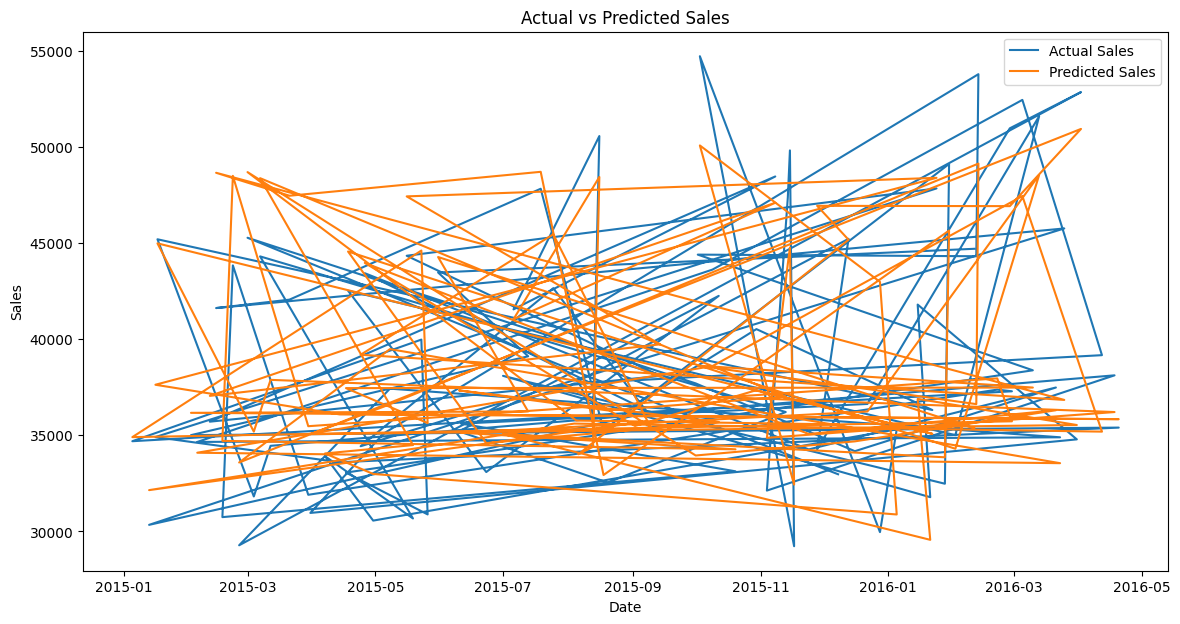

In [15]:
plt.figure(figsize=(14,7))
plt.plot(daily_sales_df['date'].iloc[-len(y_test):], y_test, label='Actual Sales')
plt.plot(daily_sales_df['date'].iloc[-len(y_test):], y_pred, label='Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Actual vs Predicted Sales')
plt.legend()
plt.show()

In [16]:
# Compute z-scores
daily_sales_df['sales_zscore'] = (daily_sales_df['sales'] - daily_sales_df['sales'].mean()) / daily_sales_df['sales'].std()

# Identify anomalies
threshold = 3  # Adjust based on your needs
anomalies = daily_sales_df[abs(daily_sales_df['sales_zscore']) > threshold]

print("Anomalous sales days:")
print(anomalies[['date', 'sales', 'sales_zscore']])

Anomalous sales days:
          date  sales  sales_zscore
316 2015-12-25     14     -5.771312


In [17]:
# Compute daily sales per category
category_daily_sales = df.groupby(['date', 'category'])['sales'].sum().compute().reset_index()

# Pivot the data
category_sales_pivot = category_daily_sales.pivot(index='date', columns='category', values='sales').fillna(0)

# Compute correlation matrix
correlation_matrix = category_sales_pivot.corr()

print("Correlation between categories:")
print(correlation_matrix)

Correlation between categories:
category       ACCESORIES  HOME_&_GARDEN  SUPERMARKET
category                                             
ACCESORIES       1.000000       0.884950     0.738675
HOME_&_GARDEN    0.884950       1.000000     0.849657
SUPERMARKET      0.738675       0.849657     1.000000


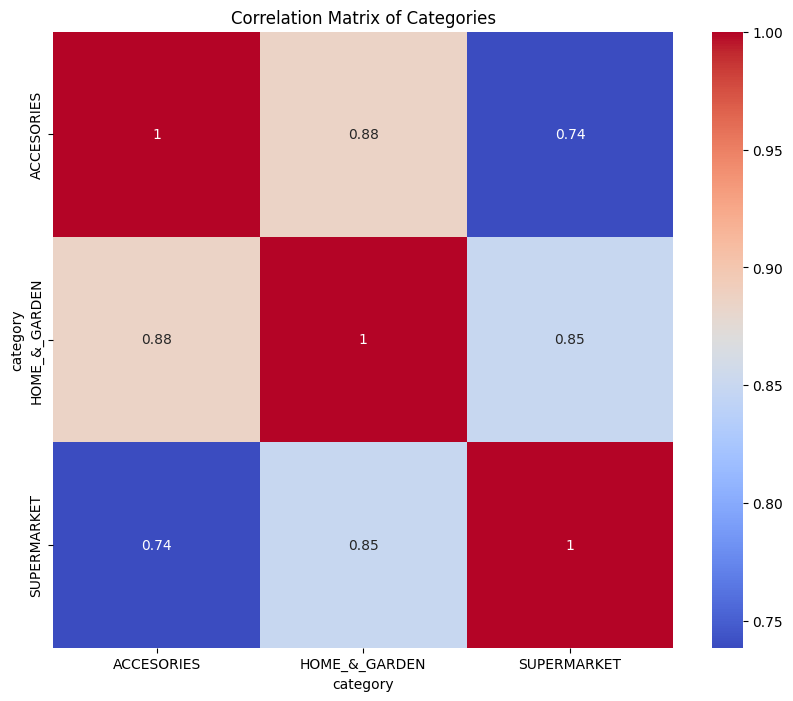

In [18]:
import seaborn as sns

plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Categories')
plt.show()

In [19]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource
from bokeh.layouts import column
output_notebook()

# Prepare data
source = ColumnDataSource(data={
    'date': daily_sales_df['date'],
    'sales': daily_sales_df['sales']
})

# Create a figure
p = figure(x_axis_type='datetime', title='Daily Sales', height=350, width=800)
p.line('date', 'sales', source=source)
p.xaxis.axis_label = 'Date'
p.yaxis.axis_label = 'Sales'

# Show the plot
show(p)

Loading BokehJS ...